In [1]:
import os
import glob
import random
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
import numpy as np
from random import uniform
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [20]:
class ConvLayer:
    def __init__(self, num_filters, filter_size):
        self.num_filters = num_filters
        self.filter_size = filter_size
        self.filters = [[[uniform(-1, 1) for _ in range(filter_size)] for _ in range(filter_size)] for _ in range(num_filters)]
        self.total_units = None  # Add total_units attribute
    
    def iterate_regions(self, image):
        h, w = len(image), len(image[0])
        for i in range(h - self.filter_size + 1):
            for j in range(w - self.filter_size + 1):
                im_region = [[image[i+x][j+y] for y in range(self.filter_size)] for x in range(self.filter_size)]
                yield im_region, i, j

    def forward(self, input):
        print(f"input shape: {np.array(input).shape}, input type: {type(input[0][0])}")
        self.last_input = input
        h, w = len(input), len(input[0])
        output = [[[0]*self.num_filters for _ in range(w - self.filter_size + 1)] for _ in range(h - self.filter_size + 1)]
        for im_region, i, j in self.iterate_regions(input):
            output[i][j] = [sum(sum(im_region[x][y] * self.filters[f][x][y] for y in range(self.filter_size)) for x in range(self.filter_size)) for f in range(self.num_filters)]
        return np.array(output)  # Convert output to numpy array

class MaxPool2:
    def __init__(self, pool_size):
        self.pool_size = pool_size
        self.total_units = None  # Add total_units attribute

    def iterate_regions(self, image):
        h, w, _ = len(image), len(image[0]), len(image[0][0])
        new_h = h // self.pool_size
        new_w = w // self.pool_size

        for i in range(new_h):
            for j in range(new_w):
                im_region = [[image[i*self.pool_size+x][j*self.pool_size+y] for y in range(self.pool_size)] for x in range(self.pool_size)]
                yield im_region, i, j

    def forward(self, input):
        self.last_input = input

        h, w, num_filters = len(input), len(input[0]), len(input[0][0])
        output = [[[0]*num_filters for _ in range(w // self.pool_size)] for _ in range(h // self.pool_size)]
    
        for im_region, i, j in self.iterate_regions(input):
            output[i][j] = [np.amax(row) for row in zip(*im_region)]
    
        return output

class Flatten:
    def forward(self, input):
        self.last_input = input

        h, w, num_filters = input.shape
        self.total_units = h * w * num_filters  # Store the total number of units

        return input.reshape(-1)  # Flatten the input
        
class Neuron:
    def __init__(self, num_inputs, activation='relu'):
        self.weights = [uniform(-1, 1) for _ in range(num_inputs)]
        self.bias = uniform(-1, 1)
        # self.output = 0
        # self.input_sum = 0
        self.activation = activation

    # Sigmoid activation
    def sigmoid(self, x):
        return 1 / (1 + (1 / self.exp(x)))

    # RELU activation
    def relu(self, x):
        return max(0, x)

    def softmax(self, x):
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum(axis=0)
        
    def activate(self):
        if self.activation == 'relu':
            self.output = self.relu(self.input_sum + self.bias)
        elif self.activation == 'sigmoid':
            self.output = self.sigmoid(self.input_sum + self.bias)
        elif self.activation == 'softmax':
            self.output = self.softmax(self.input_sum + self.bias)
        else:
            raise ValueError(f"Unknown activation function: {self.activation}")
            
    # Approximate e^x for activation function
    def exp(self, x):
        n = 1
        sum = 1
        for i in range(1, 100):
            n *= x / i
            sum += n
        return sum

    # Add method for backpropagation
    def backward(self, d_error_d_output, learning_rate):
        # Calculate the derivative of the error with respect to the input sum
        d_output_d_input_sum = 1 if self.output > 0 else 0  # Derivative of ReLU
        d_error_d_input_sum = d_error_d_output * d_output_d_input_sum

        # Calculate the derivative of the error with respect to the weights and bias
        d_error_d_weights = [d_error_d_input_sum * input for input in self.last_input]
        d_error_d_bias = d_error_d_input_sum

        # Update the weights and bias
        self.weights = [weight - learning_rate * d_error_d_weight for weight, d_error_d_weight in zip(self.weights, d_error_d_weights)]
        self.bias -= learning_rate * d_error_d_bias

        # Calculate the derivative of the error with respect to the last input
        d_error_d_last_input = [d_error_d_input_sum * weight for weight in self.weights]
        return d_error_d_last_input

class Dropout:
    def __init__(self, rate):
        self.rate = rate
        self.total_units = None  # Add total_units attribute

    def forward(self, input):
        self.last_input = input
        self.mask = [uniform(0, 1) > self.rate for _ in range(len(input))]
        return [i * m for i, m in zip(input, self.mask)]

class Layer:
    def __init__(self, num_neurons, num_inputs, activation='relu'):
        self.neurons = [Neuron(num_inputs, activation) for _ in range(num_neurons)]
        self.total_units = None  # Add total_units attribute
        
class Link:
    def __init__(self, source_neuron, target_neuron, weight):
        self.source = source_neuron
        self.target = target_neuron
        self.weight = weight

class LayerLink:
    def __init__(self, source_layer, target_layer):
        self.links = []
        for source_neuron in source_layer.neurons:
            for target_neuron in target_layer.neurons:
                link = Link(source_neuron, target_neuron, 0)
                self.links.append(link)
                target_neuron.weights.append(link.weight)

In [3]:
class Network:
    def __init__(self):
        self.layers = []
        self.layer_links = []

    def add_conv_layer(self, num_filters, filter_size):
        layer = ConvLayer(num_filters, filter_size)
        self.layers.append(layer)

    def add_softmax_layer(self, num_neurons, num_inputs=None):
        if num_inputs is None:  # If num_inputs is not provided
            num_inputs = self.layers[-1].total_units  # Use total_units of the last layer
        layer = Layer(num_neurons, num_inputs, activation='softmax')
        layer.total_units = num_neurons  # Set total_units for Layer
        self.layers.append(layer)

    # Approximate log(x) for the loss function
    def log(self, x):
        n = 50  # higher n = more accurate the approximation
        return n * (x ** (1/n) - 1)
        
    def cross_entropy_loss(self, outputs, targets):
        # Number of samples
        N = len(targets)
    
        # Calculate the cross entropy
        loss = -sum(target * self.log(output) for target, output in zip(targets, outputs)) / N
    
        return loss
        
    def initialize_weights_randomly(self):
        for layer_link in self.layer_links:
            for link in layer_link.links:
                link.weight = self.random()

    def initialize_network_from_file(self, filename):
        with open(filename, 'r') as f:
            num_layers = int(f.readline().strip())  # Read the number of layers
            print(f"Number of layers: {num_layers}")

            layer_sizes = [int(f.readline().strip()) for _ in range(num_layers)]  # Read the layer sizes
            print("Number of neurons in each layer:")

            for i, size in enumerate(layer_sizes):
                print(f"Layer {i+1}: {size} neuron(s)")

            input_size = layer_sizes[0]
            for size in layer_sizes[1:]:
                self.layers.append(Layer(size, input_size))
                input_size = size

            self.layer_links = []
            for i in range(len(self.layers) - 1):
                layer_link = LayerLink(self.layers[i], self.layers[i + 1])
                self.layer_links.append(layer_link)

    def feedforward(self, inputs):
        for i, layer in enumerate(self.layers):
            if isinstance(layer, Layer):
                next_inputs = []
                for neuron in layer.neurons:
                    neuron.input_sum = sum(w * i for w, i in zip(neuron.weights, inputs))
                    neuron.activate()
                    next_inputs.append(neuron.output)
                inputs = next_inputs
            elif isinstance(layer, ConvLayer) or isinstance(layer, MaxPool2) or isinstance(layer, Flatten):
                inputs = layer.forward(inputs)
            else:
                raise TypeError("Unsupported layer type")
        return inputs


    def train(self, inputs, targets, num_epochs, learning_rate):
        for epoch in range(num_epochs):
            for input, target in zip(inputs, targets):
                # Forward pass
                outputs = self.feedforward(input)

                # Calculate the error
                error = self.cross_entropy_loss(outputs, target)

                # Backward pass
                for layer in reversed(self.layers):
                    error = layer.backward(error, learning_rate)


def cnn_model():
    # Initialize the network
    network = Network()

    # Add convolutional layers
    network.add_conv_layer(num_filters=32, filter_size=3)
    network.layers[-1].total_units = 32 * (150 - 3 + 1) ** 2  # Set total_units for ConvLayer
    network.add_conv_layer(num_filters=64, filter_size=3)
    network.layers[-1].total_units = 64 * (148 - 3 + 1) ** 2  # Set total_units for ConvLayer

    # Add max pooling layer
    network.layers.append(MaxPool2(pool_size=2))
    network.layers[-1].total_units = 64 * (146 // 2) ** 2  # Set total_units for MaxPool2

    network.add_conv_layer(num_filters=128, filter_size=3)
    network.layers[-1].total_units = 128 * (73 - 3 + 1) ** 2  # Set total_units for ConvLayer

    network.layers.append(MaxPool2(pool_size=2))
    network.layers[-1].total_units = 128 * (71 // 2) ** 2  # Set total_units for MaxPool2

    network.add_conv_layer(num_filters=256, filter_size=3)
    network.layers[-1].total_units = 256 * (35 - 3 + 1) ** 2  # Set total_units for ConvLayer

    network.layers.append(Flatten())
    network.layers[-1].total_units = network.layers[-2].total_units  # Set total_units for Flatten

    network.layers.append(Dropout(rate=0.1))
    network.layers[-1].total_units = network.layers[-2].total_units  # Set total_units for Dropout

    # Add fully connected layers
    network.add_softmax_layer(num_neurons=512, num_inputs=network.layers[-1].total_units)
    network.layers.append(Dropout(rate=0.5))
    network.layers[-1].total_units = 512  # Set total_units for Dropout

    network.add_softmax_layer(num_neurons=256, num_inputs=512)
    network.layers.append(Dropout(rate=0.5))
    network.layers[-1].total_units = 256  # Set total_units for Dropout

    network.add_softmax_layer(num_neurons=10, num_inputs=256)

    # Check total_units
    for layer in network.layers:
        if layer.total_units is None:
            raise ValueError(f"total_units is not set for {layer}")

    return network

In [4]:
# !gdown "1WceM5HuxdSiQBzMvhLdKZH88xohgCXaw"
# !gdown "19YfHt_7cdSePo6KLSCmJthWLKRVxJKLw"
# !gdown "1hmOBV7fIEgsmLFaHv5r-GSQuQfHCWPUP"
# !unzip shoe_sandal_boot.zip
# !unzip "Flower Image Dataset.zip"
# !unzip "Intel Image Classification.zip"

(1191, 670, 3)


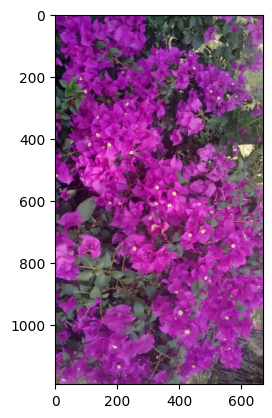

In [5]:
img = cv2.imread(f'flowers/bougainvillea_00002.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
print(img.shape)
del img

In [11]:
def load_dataset(dataset_path):
    images = []
    labels = []
    for filename in os.listdir(dataset_path):
        if filename.endswith(".jpg"):
            img = Image.open(os.path.join(dataset_path, filename))
            images.append(img)
            label = filename.split('_')[0]  # Extract label from filename
            labels.append(label)
    return images, labels

def preprocess_dataset(images, labels):
    # Resize images and convert to grayscale
    images = [img.resize((150, 150)).convert('L') for img in images]  # Resize to 150x150 and convert to grayscale

    # Convert images to numpy arrays and normalize
    images = [np.array(img, dtype=np.float32) / 255.0 for img in images]  

    # Print the shape of the first image
    print(f"Shape of the first image: {images[0].shape}")

    # Convert labels to one-hot encoding
    label_to_index = {label: i for i, label in enumerate(set(labels))}
    labels = [label_to_index[label] for label in labels]
    labels = np.eye(len(label_to_index))[labels]  # One-hot encoding

    return np.array(images), np.array(labels), label_to_index

# Load the dataset
images, labels = load_dataset('flowers')

# Preprocess the dataset
images, labels, label_to_index = preprocess_dataset(images, labels)

# After preprocessing
print(type(images[0]))  # Should print: <class 'numpy.ndarray'>
print(images[0].dtype)  # Should print: float32 or float64
print(images[0].shape)  # Should print: (150, 150)

Shape of the first image: (150, 150)
<class 'numpy.ndarray'>
float32
(150, 150)


In [21]:
# Create the CNN model
network = cnn_model()

# Set your training parameters
num_epochs = 10  # Number of times the entire dataset will be passed through the network
learning_rate = 0.001  # The step size for weight updates

# Start training the model
network.train(images, labels, num_epochs, learning_rate)

input shape: (150, 150), input type: <class 'numpy.float32'>
input shape: (148, 148, 32), input type: <class 'numpy.ndarray'>
input shape: (73, 73, 2), input type: <class 'list'>


TypeError: can't multiply sequence by non-int of type 'float'